In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
from torchvision.models.vgg import VGG
import scipy.misc
import random
import sys

if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2

from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt
import numpy as np
import time
import os

## Define FCN16s model for deconvolution layers

In [3]:
class FCN16s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace = True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)
        
        return score

## Define VGG16 for convolution layers

In [4]:
class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):      
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x
        return output

In [5]:
ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

## Define training parameter

## Define path, directory trainning environment

In [14]:
means     = np.array([103.939, 116.779, 123.68]) / 255. # mean of three channels in the order of BGR
h, w      = 480, 640
n_class = 4

# create dir for model
model_dir = "models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

use_gpu = torch.cuda.is_available()
num_gpu = list(range(torch.cuda.device_count()))

vgg_model = VGGNet(requires_grad=True, remove_fc=True)
fcn_model = FCN16s(pretrained_net=vgg_model, n_class=n_class)
#use_gpu = False
if use_gpu:
    ts = time.time()
    vgg_model = vgg_model.cuda()
    fcn_model = fcn_model.cuda()
    fcn_model = nn.DataParallel(fcn_model, device_ids=num_gpu)
    print("Finish cuda loading, time elapsed {}".format(time.time() - ts))

Finish cuda loading, time elapsed 0.014281034469604492


## Visualize model

In [15]:
def test(model_name, img, origin):
    state_dict = torch.load(os.path.join(model_dir, model_name))
    fcn_model.load_state_dict(state_dict)

    # convert to tensor
    img = img[np.newaxis,:]
    img = torch.from_numpy(img.copy()).float() 
    output = fcn_model(img)
    output = output.data.cpu().numpy()

    N, _, h, w = output.shape
    pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis = 1).reshape(N, h, w)

    # show images
    
    img = img.numpy()
    for i in range(N):
        plt.figure()
        plt.title("origin_img")
        plt.imshow(origin)
        plt.figure()
        plt.title("prediction")
        plt.imshow(pred[i],cmap = "brg",vmin = 0, vmax = n_class - 1)

    torch.save(fcn_model.module.state_dict(), "99" + '.pth')
    plt.show()
    return pred[0]

In [16]:
## img process
img        = cv2.imread("1.jpg",cv2.IMREAD_UNCHANGED)
origin     = img
origin1     = cv2.cvtColor(origin, cv2.COLOR_BGR2RGB)
img        = img[:, :, ::-1]  # switch to BGR

img = np.transpose(img, (2, 0, 1)) / 255.
img[0] -= means[0]
img[1] -= means[1]
img[2] -= means[2]

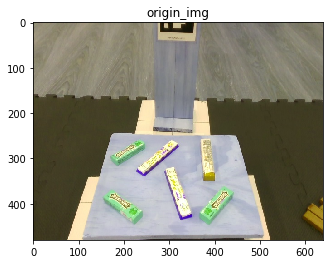

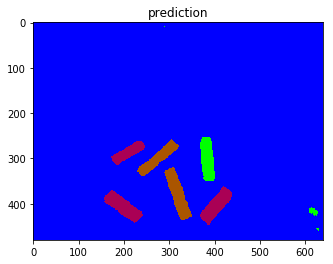

[0 1 2 3]


In [17]:
mask = test("sis_99epoch.pkl", img, origin)
print(np.unique(mask))

In [18]:
class ShapeDetector:
    def __init__(self):
        pass
    def detect(self, c):
        # initialize the shape name and approximate the contour
        shape = "unidentified"
        peri = cv2.arcLength(c, True)
        c1 = cv2.convexHull(c)
        approx = cv2.approxPolyDP(c1, 0.04 * peri, True)
        # if the shape is a triangle, it will have 3 vertices
        if len(approx) == 3:
            shape = "triangle"
        # if the shape has 4 vertices, it is either a square or
        # a rectangle
        elif len(approx) == 4:
            # compute the bounding box of the contour and use the
            # bounding box to compute the aspect ratio
            (x, y, w, h) = cv2.boundingRect(approx)
            ar = w / float(h)
            shape = "square" if ar >= 0.9 and ar <= 1.1 else "rectangle"
            if h < 5 or w < 5:
                shape = "unidentified" 
        return shape

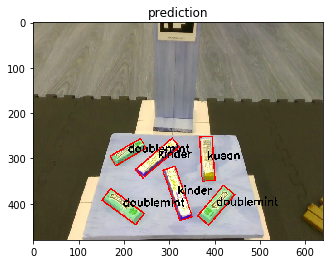

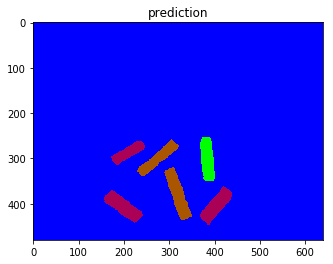

In [19]:
MAXAREA = 18000
MINAREA = 1000
brand = ['doublemint', 'kinder', 'kusan']
show_img = np.asarray(origin)
m = np.zeros(((h, w)))
mask = np.asarray(mask, np.uint8)
mask2 = np.zeros((h, w))
for i in range(1, n_class):
    mask1 = np.zeros((h, w))
    mask1[mask == i] = 1
    mask1 = np.asarray(mask1, np.uint8)
    mask1 = cv2.GaussianBlur(mask1, (5, 5), 0)
#     mask1 = cv2.erode(mask1,None, iterations = 6)
#     mask1 = cv2.dilate(mask1, None, iterations = 6)
    
    cnts = cv2.findContours(mask1.copy(), cv2.RETR_CCOMP  ,cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[1]
    sd = ShapeDetector()
    for c in cnts:
        if MAXAREA >= cv2.contourArea(c) >= MINAREA:
            shape = sd.detect(c)
            if shape is "rectangle":
                M = cv2.moments(c)
                if M["m00"] == 0 :
                    break
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                
                rect = cv2.minAreaRect(c)
                box = cv2.boxPoints(rect)
                box = np.int0(box)

                cv2.drawContours(show_img,[box], 0, (255, 0, 0), 2)
                cv2.putText(show_img, brand[i - 1], (cX, cY), cv2.FONT_HERSHEY_SIMPLEX,0.8, (0, 0, 0), 2)
                _, labels = cv2.connectedComponents(mask)
                p = labels[c[0,0,1],c[0,0,0]]
                mask2[labels == p] = i
                
    
plt.figure()
plt.title("prediction")
plt.imshow(show_img, cmap = "brg")
cv2.imwrite("result.jpg", show_img)
plt.figure()
plt.title("prediction")
plt.imshow(mask2,cmap = "brg",vmin = 0, vmax = n_class - 1)

In [20]:
cv2.__version__

'3.4.3'